#Importing Required Packages 

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold,cross_val_score,train_test_split
from sklearn.linear_model import LinearRegression,Lasso,LassoCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.decomposition import PCA
import xgboost
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score

# Loading Data

In [3]:
#read the data
tdata = pd.read_csv(r"E:\AV\Return_path\assessment_challenge.csv")

In [4]:
tdata.head()

,id,read_rate,from_domain_hash,Domain_extension,day,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
0,1,0.142857,27b0d9f2946586e2714e3b4312bc8207,br,Sat,14,14,0.090180,0.104208,0.184311,0.205275,0.214286,0.428571,0.000000,0.000000,0,0.142857,0.214286,0
1,2,0.000000,b10a5c38ffad692959a42353fd2896f2,com,Wed,39,39,0.005406,0.008427,0.058590,0.000000,0.128205,0.102564,0.410256,0.153846,0,0.179487,0.025641,0
2,3,0.500000,f8a9fa3e4cbeb4436c4eaf9183df2cbf,com,Fri,18,2,0.302676,0.970434,0.055645,0.433333,0.000000,0.000000,0.500000,0.000000,0,0.000000,0.500000,0
3,4,0.134615,6dc9420f4bcb2746186f64cf5072d1fa,com,Sun,52,52,0.141473,0.776517,0.169429,0.182516,0.196078,0.215686,0.294118,0.176471,0,0.078431,0.039216,0
4,5,0.000000,a37f0e9827536a9bb709b1b505d57aa9,com,Sun,17,17,0.018936,0.028425,0.052422,0.000000,0.058824,0.294118,0.176471,0.176471,0,0.235294,0.058824,0


In [5]:
#Column names
tdata.columns

Index([u'id', u'read_rate', u'from_domain_hash', u'Domain_extension', u'day',
       u'campaign_size', u'unique_user_cnt', u'avg_domain_read_rate',
       u'avg_domain_inbox_rate', u'avg_user_avg_read_rate',
       u'avg_user_domain_avg_read_rate', u'mb_superuser', u'mb_engper',
       u'mb_supersub', u'mb_engsec', u'mb_inper', u'mb_insec', u'mb_unengsec',
       u'mb_idlesub'],
      dtype='object')

In [6]:
#See how data is distributed in each column
tdata.describe()

,id,read_rate,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
count,59976.000000,59976.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000,59975.000000
mean,29988.500000,0.094646,143.258041,129.491071,0.107053,0.461029,0.086192,0.076427,0.103915,0.246325,0.228185,0.149990,0.016864,0.135194,0.105345,0.001876
std,17313.724209,0.165697,1218.725723,992.785980,0.127793,0.398551,0.077821,0.131760,0.110716,0.164119,0.139179,0.105111,0.060599,0.132990,0.100545,0.022579
min,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14994.750000,0.000000,15.000000,14.000000,0.009264,0.018170,0.036402,0.000000,0.028037,0.142857,0.136364,0.083333,0.000000,0.038710,0.040541,0.000000
50%,29988.500000,0.017241,24.000000,22.000000,0.061572,0.540357,0.065918,0.011342,0.080000,0.221429,0.230769,0.145329,0.000000,0.103896,0.090909,0.000000
75%,44982.250000,0.125000,57.000000,52.000000,0.176065,0.903305,0.115383,0.106667,0.149493,0.321043,0.308511,0.204324,0.000000,0.200000,0.150000,0.000000
max,59976.000000,1.000000,121817.000000,112439.000000,1.000000,1.000000,0.996852,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


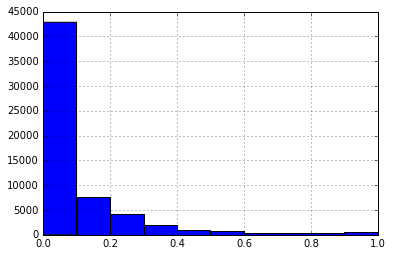

In [52]:
#Distribution of target variable, highly skewed
tdata.read_rate.hist()

In [8]:
#Removing columns with variance of 0 [constant columsn]
panel = tdata
# removing constant columns
for colname in panel.columns:
    if len(np.unique(panel[colname].values.astype("str"))) == 1:
        del panel[colname]
        print("Column %s has zero variance and is removed from data" % (colname))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000022C382E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000031C120B8>]], dtype=object)

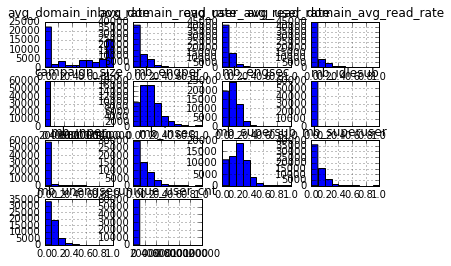

In [126]:
#distribution of each column 
tdata.hist()

In [9]:
# List Percentage of missing values 
percent_of_missing_train  = tdata.apply(lambda x :  (float(sum(x.isnull()))/len(x))*100 )

print "Train data has "+str(len(percent_of_missing_train[percent_of_missing_train > 5]))+" columsn with more than 5% missing"

Train data has 0 columsn with more than 5% missing


In [105]:
percent_of_missing_train

id                               0.000000
read_rate                        0.000000
from_domain_hash                 0.000000
Domain_extension                 0.008337
day                              0.001667
campaign_size                    0.001667
unique_user_cnt                  0.001667
avg_domain_read_rate             0.001667
avg_domain_inbox_rate            0.001667
avg_user_avg_read_rate           0.001667
avg_user_domain_avg_read_rate    0.001667
mb_superuser                     0.001667
mb_engper                        0.001667
mb_supersub                      0.001667
mb_engsec                        0.001667
mb_inper                         0.001667
mb_insec                         0.001667
mb_unengsec                      0.001667
mb_idlesub                       0.001667
dtype: float64

In [10]:
#Only one row has missing value in all columns
#droping all na's
tdata.dropna(inplace=True)

In [26]:
#Removing following columns and creating a trainning dataset
#Id : unique identifier
#from_domain_hash : more than 390 levels
#Domain_extension : more than 25k levels
#from_domain_hash : unique and more number of level
#read_rate : target variable
train_data = tdata.drop(['id','from_domain_hash','Domain_extension','read_rate'],axis=1)

In [27]:
#Creating dummy variables for column "day"
train = pd.get_dummies(train_data, columns= ['day'])
predictors = train.columns

In [28]:
#form a matrix from data frame
train_data = train.as_matrix()

In [29]:
#creating a dataset with only independent variables
train_res = tdata['read_rate'].as_matrix()

##Modeling

In [16]:
#Linear Regression
LR = LinearRegression(n_jobs=-1)

#performing 10 fold cross validation
LR_Cross_val = cross_val_score(LR,train_data,train_res,cv=10,scoring = 'r2').mean()

print "CV Score for Linear Regression(r2) : "+str(LR_Cross_val)

CV Score for Linear Regression(r2) : 0.714961999347


In [17]:
#Tunning Alpha for Lasso 
#R2 value decreases with increase in apha 
for i in np.arange(0.001,0.05,0.01) :
    las = Lasso(alpha=i)
    print "Aplha ="+str(i)+"    CV: "+str(cross_val_score(las,train_data,train_res,cv=10,scoring = 'r2').mean())

Aplha =0.001    CV: 0.697005621295
Aplha =0.011    CV: 0.399364941902
Aplha =0.021    CV: 0.1127556921
Aplha =0.031    CV: -2.80898890439e-05
Aplha =0.041    CV: -2.62458330036e-05


In [19]:
#Fitting Lasso
las = Lasso(alpha=0.001)

Las_CV = cross_val_score(las,train_data,train_res,cv=10,scoring = 'r2').mean()

print "CV Score for Lasso(r2)  : %0.6f "%(Las_CV)

CV Score for Lasso(r2)  : 0.697006 


In [ ]:
#Fitting RandomeForest with 600 estimators
rf = RandomForestRegressor(n_estimators = 600,n_jobs=-1)

RF_cross_val = cross_val_score(rf,train_data,train_res,cv=5,scoring = 'r2').mean()

print "CV Score for RandomForest  : "+str(RF_cross_val)

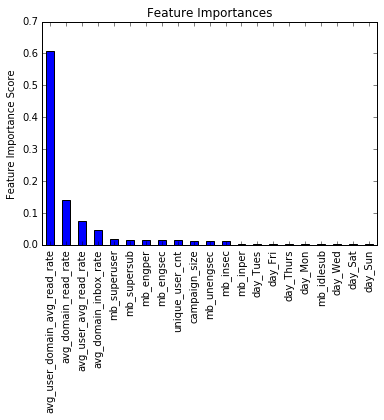

In [24]:
rf.fit(train_data,train_res)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#Fitting GradientBoosting model with tunned parametrs
#Performed Tunning of parametrs and identified the optimal values for each of parameter

gbm = GradientBoostingRegressor(learning_rate=0.01, n_estimators=600,max_depth=11,
                                                              min_samples_split=200, min_samples_leaf=60,
                                                              subsample=0.8, random_state=10,max_features=10)
    
gbm_cross_val = cross_val_score(gbm,train_data,train_res,cv=5,scoring = 'r2').mean()

print "CV Score for GradientBoosting  : "+str(gbm_cross_val)

In [ ]:
#Tunning of parameters for Xgboost
#Saving the result in csv file
parameters = {
        'n_estimators': [ 600,1200],
        'learning_rate': [0.01,0.005],
        'max_depth': [9,11],
        'subsample': [0.8]
}

xgb_model = xgboost.XGBRegressor()
clf = GridSearchCV(xgb_model, parameters, n_jobs= 3, cv=5,scoring ="r2")

clf.fit(train_data,train_res)

score = []
par = {'n_estimators':[],'learning_rate':[],
       'max_depth':[],'subsample':[],
      'scores':[]
      }

for i in clf.grid_scores_:
    par['scores'].append(i[1])
    for k in i[0].keys() :
        par[k].append( i[0][k])

pd.DataFrame(par).to_csv(r'E:\AV\Return_path\xgboost_tune_parameters.csv')